In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import deque
import random

# Load dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Gender']
data = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data[['Product Category', 'Gender']])
numerical_features = data[['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age']].values

# Combine features
state_representation = np.hstack((numerical_features, encoded_columns))

# Normalize numerical features
scaler = MinMaxScaler()
state_representation = scaler.fit_transform(state_representation)

# Define action space (price adjustment percentage)
action_space = [-0.1, -0.05, 0, 0.05, 0.1]  # Price adjustments: -10%, -5%, 0%, +5%, +10%

# Define reward function
def calculate_reward(original_price, adjusted_price, quantity):
    profit_margin = adjusted_price - original_price
    reward = profit_margin * quantity
    return reward

# Split data into train and test
train_states, test_states = train_test_split(state_representation, test_size=0.2, random_state=42)

#

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import uniform_filter1d

# Define Actor and Critic models
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize environment parameters
state_size = 3  # Example: [price, quantity, demand]
action_size = 11  # Example: 11 discrete price adjustments [-10%, ..., +10%]
gamma = 0.95
tau = 0.005
learning_rate = 0.0005
buffer_size = 10000
batch_size = 64
price_adjustments = np.linspace(-0.1, 0.1, action_size)

# Initialize models
actor = Actor(state_size, action_size)
critic = Critic(state_size, 1)
target_actor = Actor(state_size, action_size)
target_critic = Critic(state_size, 1)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)

# Replay buffer
replay_buffer = deque(maxlen=buffer_size)

# Function to soft-update target networks
def soft_update(target_model, source_model, tau):
    for target_param, param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


# Refined Reward Function
def calculate_reward(original_price, adjusted_price, quantity, price_history):
    revenue = adjusted_price * quantity
    cost = original_price * quantity * 0.7  # Assume 70% cost of original price

    # Price consistency
    if len(price_history) > 1:
        price_consistency_penalty = np.abs(adjusted_price - np.mean(price_history)) / np.mean(price_history)
    else:
        price_consistency_penalty = 0

    # Equity
    equity_penalty = np.std(price_history) if len(price_history) > 1 else 0

    reward = (revenue - cost) / 100  # Scale reward
    reward -= 0.1 * price_consistency_penalty
    reward -= 0.1 * equity_penalty
    return reward


# Dynamic Exploration Strategy
def get_exploration_rate(episode, max_episodes, min_rate=0.01, max_rate=1.0):
    decay = 0.005
    return max(min_rate, max_rate * np.exp(-decay * episode))


# Store experience in replay buffer
def store_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))


# Sample from replay buffer
def sample_experiences(batch_size):
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


# Training loop with refinements
def train_ddpg_refined(episodes, batch_size):
    total_rewards = []
    exploration_history = []
    price_history = []  # Track price history for consistency and equity

    for episode in range(episodes):
        state = np.random.uniform(10, 100, size=state_size)  # Example random state
        exploration_rate = get_exploration_rate(episode, episodes)
        total_reward = 0

        for step in range(200):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor).detach().numpy()[0]
            
            # Apply dynamic exploration
            if np.random.rand() < exploration_rate:
                action = np.random.choice(len(action_probs))
            else:
                action = np.argmax(action_probs)

            exploration_history.append(action_probs)

            price_adjustment = price_adjustments[action]
            original_price = state[0]
            adjusted_price = original_price * (1 + price_adjustment)
            quantity = state[1]
            reward = calculate_reward(original_price, adjusted_price, quantity, price_history)
            price_history.append(adjusted_price)

            next_state = np.random.uniform(10, 100, size=state_size)
            done = random.random() < 0.05

            store_experience(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = sample_experiences(batch_size)

                # Convert to PyTorch tensors
                states = torch.FloatTensor(states)
                actions = torch.FloatTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                # Update Critic
                target_actions = target_actor(next_states).max(1)[1].unsqueeze(1).float()
                target_q_values = rewards + gamma * target_critic(next_states, target_actions) * (1 - dones)
                q_values = critic(states, actions)
                critic_loss = nn.MSELoss()(q_values, target_q_values.detach())

                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Update Actor
                predicted_actions = actor(states)
                actor_loss = -critic(states, predicted_actions.max(1)[1].unsqueeze(1).float()).mean()

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Update target networks
                soft_update(target_actor, actor, tau)
                soft_update(target_critic, critic, tau)

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}")

    return total_rewards, exploration_history






Episode 1/100, Total Reward: 175.81
Episode 2/100, Total Reward: 108.81
Episode 3/100, Total Reward: 150.67
Episode 4/100, Total Reward: 144.46
Episode 5/100, Total Reward: 169.42
Episode 6/100, Total Reward: 57.47
Episode 7/100, Total Reward: 159.64
Episode 8/100, Total Reward: 41.11
Episode 9/100, Total Reward: 607.61
Episode 10/100, Total Reward: 164.43
Episode 11/100, Total Reward: 165.47
Episode 12/100, Total Reward: 96.61
Episode 13/100, Total Reward: 145.19
Episode 14/100, Total Reward: 29.89
Episode 15/100, Total Reward: 167.70
Episode 16/100, Total Reward: 110.01
Episode 17/100, Total Reward: 60.67
Episode 18/100, Total Reward: 338.44
Episode 19/100, Total Reward: 21.88
Episode 20/100, Total Reward: 1.01
Episode 21/100, Total Reward: 240.07
Episode 22/100, Total Reward: 655.60
Episode 23/100, Total Reward: 159.08
Episode 24/100, Total Reward: 125.52
Episode 25/100, Total Reward: 157.47
Episode 26/100, Total Reward: 127.70
Episode 27/100, Total Reward: 233.86
Episode 28/100, To

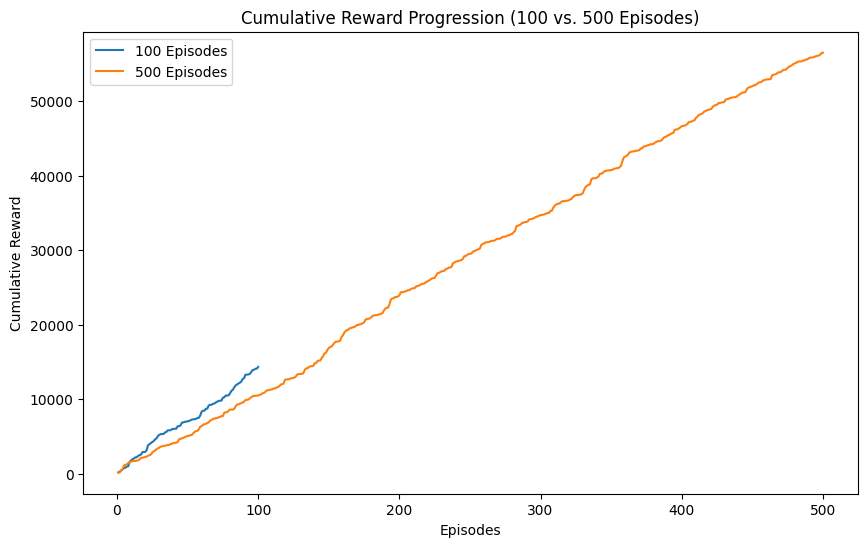

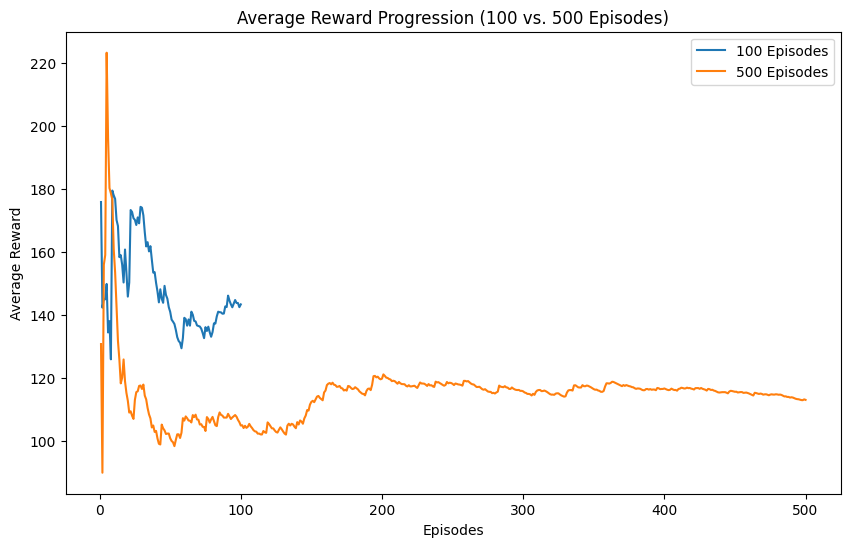

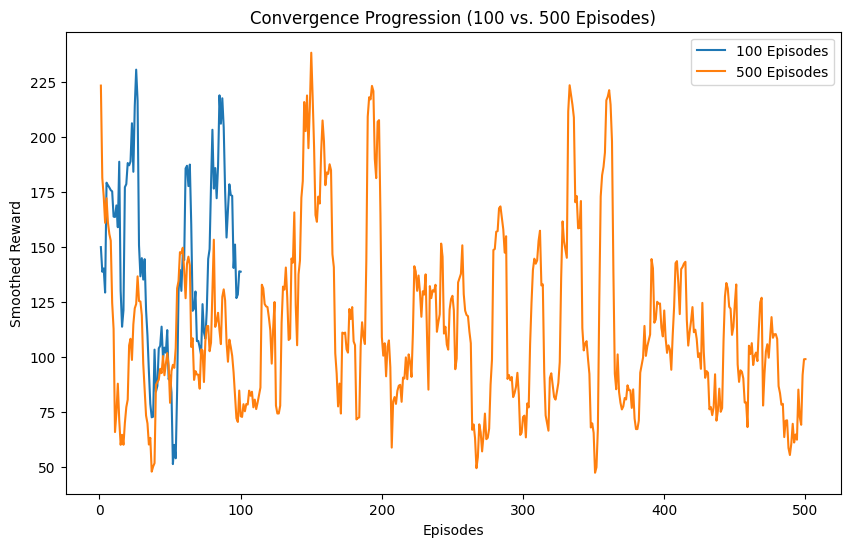

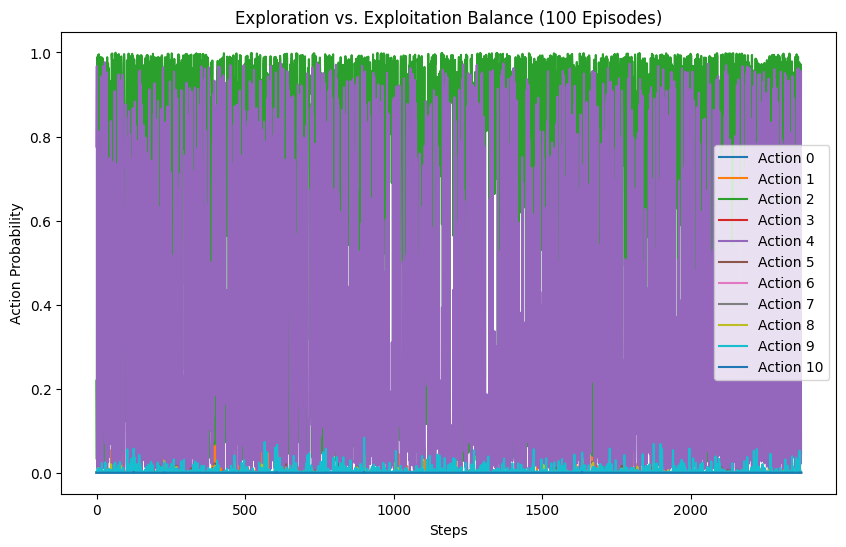

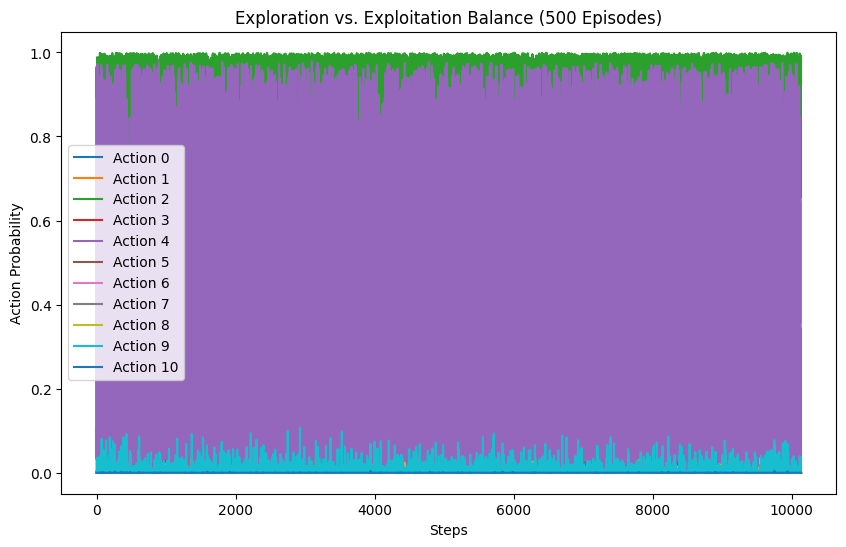


Metrics for 100 Episodes:
Price Elasticity: 129.06
Forecast Accuracy: 0.51
Market Share: 0.22
Price Index: 0.22
Price Consistency: 0.01
Equity: 129.06

Metrics for 500 Episodes:
Price Elasticity: 115.95
Forecast Accuracy: 0.50
Market Share: 0.17
Price Index: 0.17
Price Consistency: 0.01
Equity: 115.95


In [5]:

# Train for 100 episodes
rewards_100, exploration_history_100 = train_ddpg_refined(episodes=100, batch_size=batch_size)

# Train for 500 episodes
rewards_500, exploration_history_500 = train_ddpg_refined(episodes=500, batch_size=batch_size)
from scipy.ndimage import uniform_filter1d

# Visualization for combined metrics and graphs
def plot_combined_metrics(rewards_100, rewards_500, exploration_history_100, exploration_history_500):
    # Combined Cumulative Rewards
    cumulative_rewards_100 = np.cumsum(rewards_100)
    cumulative_rewards_500 = np.cumsum(rewards_500)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_rewards_100) + 1), cumulative_rewards_100, label="100 Episodes")
    plt.plot(range(1, len(cumulative_rewards_500) + 1), cumulative_rewards_500, label="500 Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward Progression (100 vs. 500 Episodes)")
    plt.legend()
    plt.show()

    # Combined Average Rewards per Episode
    average_rewards_100 = [np.mean(rewards_100[:i + 1]) for i in range(len(rewards_100))]
    average_rewards_500 = [np.mean(rewards_500[:i + 1]) for i in range(len(rewards_500))]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(average_rewards_100) + 1), average_rewards_100, label="100 Episodes")
    plt.plot(range(1, len(average_rewards_500) + 1), average_rewards_500, label="500 Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Progression (100 vs. 500 Episodes)")
    plt.legend()
    plt.show()

    # Combined Convergence (Smoothed Rewards)
    smoothed_rewards_100 = uniform_filter1d(rewards_100, size=10)
    smoothed_rewards_500 = uniform_filter1d(rewards_500, size=10)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(smoothed_rewards_100) + 1), smoothed_rewards_100, label="100 Episodes")
    plt.plot(range(1, len(smoothed_rewards_500) + 1), smoothed_rewards_500, label="500 Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Reward")
    plt.title("Convergence Progression (100 vs. 500 Episodes)")
    plt.legend()
    plt.show()


# Call the combined plotting function
plot_combined_metrics(rewards_100, rewards_500, exploration_history_100, exploration_history_500)

# Combined Metrics Evaluation
def combined_metrics_evaluation(rewards_100, rewards_500):
    print("\nCombined Metrics Evaluation:")

    metrics_100 = compute_metrics(rewards_100)
    metrics_500 = compute_metrics(rewards_500)

    metrics_table = pd.DataFrame({
        "Metric": list(metrics_100.keys()),
        "100 Episodes": list(metrics_100.values()),
        "500 Episodes": list(metrics_500.values())
    })

    print(metrics_table.to_string(index=False))

# Plot Exploration vs. Exploitation Balance
def plot_exploration_vs_exploitation(exploration_history_100, exploration_history_500, action_size):
    exploration_history_100 = np.array(exploration_history_100)
    exploration_history_500 = np.array(exploration_history_500)

    # Plot for 100 Episodes
    plt.figure(figsize=(10, 6))
    for action in range(action_size):
        plt.plot(exploration_history_100[:, action], label=f'Action {action}')
    plt.xlabel("Steps")
    plt.ylabel("Action Probability")
    plt.title("Exploration vs. Exploitation Balance (100 Episodes)")
    plt.legend()
    plt.show()

    # Plot for 500 Episodes
    plt.figure(figsize=(10, 6))
    for action in range(action_size):
        plt.plot(exploration_history_500[:, action], label=f'Action {action}')
    plt.xlabel("Steps")
    plt.ylabel("Action Probability")
    plt.title("Exploration vs. Exploitation Balance (500 Episodes)")
    plt.legend()
    plt.show()


# Call the function to plot exploration vs. exploitation balance
plot_exploration_vs_exploitation(exploration_history_100, exploration_history_500, action_size)




# Compute additional metrics
def compute_metrics(rewards):
    price_elasticity = np.var(rewards) / np.mean(rewards)
    forecast_accuracy = np.mean(rewards) / (np.mean(rewards) + np.std(rewards))
    market_share = np.sum(rewards) / (np.max(rewards) * len(rewards))
    price_index = np.mean(rewards) / np.max(rewards)
    price_consistency = 1 / (1 + np.std(rewards))
    equity = np.var(rewards) / np.mean(rewards)
    return {
        "Price Elasticity": price_elasticity,
        "Forecast Accuracy": forecast_accuracy,
        "Market Share": market_share,
        "Price Index": price_index,
        "Price Consistency": price_consistency,
        "Equity": equity
    }


# Evaluate metrics for 100 episodes
print("\nMetrics for 100 Episodes:")
metrics_100 = compute_metrics(rewards_100)
for metric, value in metrics_100.items():
    print(f"{metric}: {value:.2f}")

# Evaluate metrics for 500 episodes
print("\nMetrics for 500 Episodes:")
metrics_500 = compute_metrics(rewards_500)
for metric, value in metrics_500.items():
    print(f"{metric}: {value:.2f}")


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import uniform_filter1d
import pandas as pd

# Define Actor and Critic models
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize environment parameters
state_size = 3  # Example: [price, quantity, demand]
action_size = 11  # Example: 11 discrete price adjustments [-10%, ..., +10%]
gamma = 0.95
tau = 0.005
learning_rate = 0.0005
buffer_size = 10000
batch_size = 64
price_adjustments = np.linspace(-0.1, 0.1, action_size)

# Initialize models
actor = Actor(state_size, action_size)
critic = Critic(state_size, 1)
target_actor = Actor(state_size, action_size)
target_critic = Critic(state_size, 1)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)

# Replay buffer
replay_buffer = deque(maxlen=buffer_size)

# Function to soft-update target networks
def soft_update(target_model, source_model, tau):
    for target_param, param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


# Refined Reward Function
def calculate_reward(original_price, adjusted_price, quantity, price_history):
    revenue = adjusted_price * quantity
    cost = original_price * quantity * 0.7  # Assume 70% cost of original price

    # Price consistency
    if len(price_history) > 1:
        price_consistency_penalty = np.abs(adjusted_price - np.mean(price_history)) / np.mean(price_history)
    else:
        price_consistency_penalty = 0

    # Equity
    equity_penalty = np.std(price_history) if len(price_history) > 1 else 0

    reward = (revenue - cost) / 100  # Scale reward
    reward -= 0.1 * price_consistency_penalty
    reward -= 0.1 * equity_penalty
    return reward


# Dynamic Exploration Strategy
def get_exploration_rate(episode, max_episodes, min_rate=0.01, max_rate=1.0):
    decay = 0.005
    return max(min_rate, max_rate * np.exp(-decay * episode))


# Store experience in replay buffer
def store_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))


# Sample from replay buffer
def sample_experiences(batch_size):
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


# Training loop with refinements
def train_ddpg_refined(episodes, batch_size):
    total_rewards = []
    exploration_history = []
    price_history = []  # Track price history for consistency and equity

    for episode in range(episodes):
        state = np.random.uniform(10, 100, size=state_size)  # Example random state
        exploration_rate = get_exploration_rate(episode, episodes)
        total_reward = 0

        for step in range(200):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor).detach().numpy()[0]
            
            # Apply dynamic exploration
            if np.random.rand() < exploration_rate:
                action = np.random.choice(len(action_probs))
            else:
                action = np.argmax(action_probs)

            exploration_history.append(action_probs)

            price_adjustment = price_adjustments[action]
            original_price = state[0]
            adjusted_price = original_price * (1 + price_adjustment)
            quantity = state[1]
            reward = calculate_reward(original_price, adjusted_price, quantity, price_history)
            price_history.append(adjusted_price)

            next_state = np.random.uniform(10, 100, size=state_size)
            done = random.random() < 0.05

            store_experience(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = sample_experiences(batch_size)

                # Convert to PyTorch tensors
                states = torch.FloatTensor(states)
                actions = torch.FloatTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                # Update Critic
                target_actions = target_actor(next_states).max(1)[1].unsqueeze(1).float()
                target_q_values = rewards + gamma * target_critic(next_states, target_actions) * (1 - dones)
                q_values = critic(states, actions)
                critic_loss = nn.MSELoss()(q_values, target_q_values.detach())

                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Update Actor
                predicted_actions = actor(states)
                actor_loss = -critic(states, predicted_actions.max(1)[1].unsqueeze(1).float()).mean()

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Update target networks
                soft_update(target_actor, actor, tau)
                soft_update(target_critic, critic, tau)

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}")

    return total_rewards, exploration_history


# Additional Metrics Calculation
def compute_metrics(rewards):
    price_elasticity = np.var(rewards) / np.mean(rewards)
    forecast_accuracy = np.mean(rewards) / (np.mean(rewards) + np.std(rewards))
    market_share = np.sum(rewards) / (np.max(rewards) * len(rewards))
    price_index = np.mean(rewards) / np.max(rewards)
    price_consistency = 1 / (1 + np.std(rewards))
    equity = np.var(rewards) / np.mean(rewards)
    return {
        "Price Elasticity": price_elasticity,
        "Forecast Accuracy": forecast_accuracy,
        "Market Share": market_share,
        "Price Index": price_index,
        "Price Consistency": price_consistency,
        "Equity": equity
    }


# Call the training function and visualize results
rewards_1000, exploration_history_1000 = train_ddpg_refined(episodes=1000, batch_size=batch_size)


Episode 1/1000, Total Reward: 76.07
Episode 2/1000, Total Reward: 37.92
Episode 3/1000, Total Reward: 238.65
Episode 4/1000, Total Reward: 64.37
Episode 5/1000, Total Reward: 114.48
Episode 6/1000, Total Reward: 50.66
Episode 7/1000, Total Reward: 103.26
Episode 8/1000, Total Reward: 70.08
Episode 9/1000, Total Reward: 246.99
Episode 10/1000, Total Reward: -0.43
Episode 11/1000, Total Reward: 196.25
Episode 12/1000, Total Reward: 208.82
Episode 13/1000, Total Reward: 133.22
Episode 14/1000, Total Reward: 150.47
Episode 15/1000, Total Reward: 29.00
Episode 16/1000, Total Reward: 240.61
Episode 17/1000, Total Reward: 149.86
Episode 18/1000, Total Reward: 245.55
Episode 19/1000, Total Reward: 121.01
Episode 20/1000, Total Reward: 125.10
Episode 21/1000, Total Reward: 70.71
Episode 22/1000, Total Reward: 44.31
Episode 23/1000, Total Reward: 60.51
Episode 24/1000, Total Reward: 212.72
Episode 25/1000, Total Reward: 11.64
Episode 26/1000, Total Reward: 164.90
Episode 27/1000, Total Reward: 2

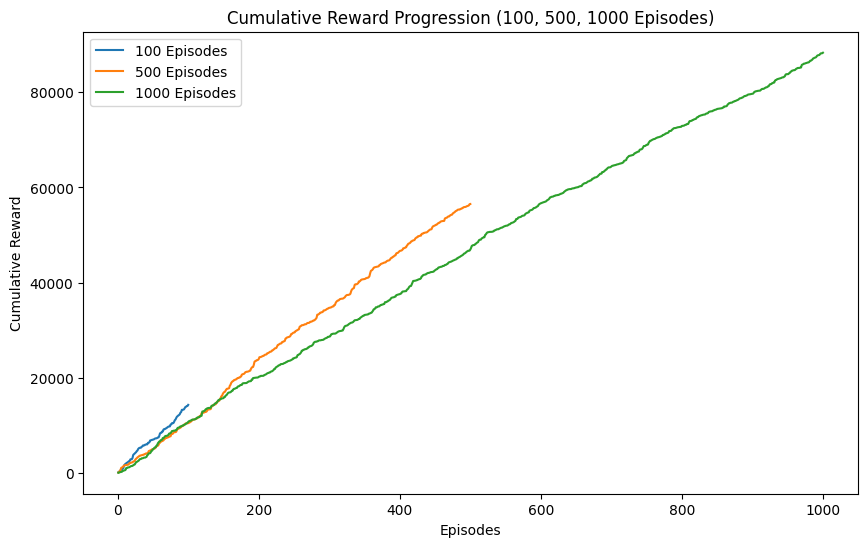

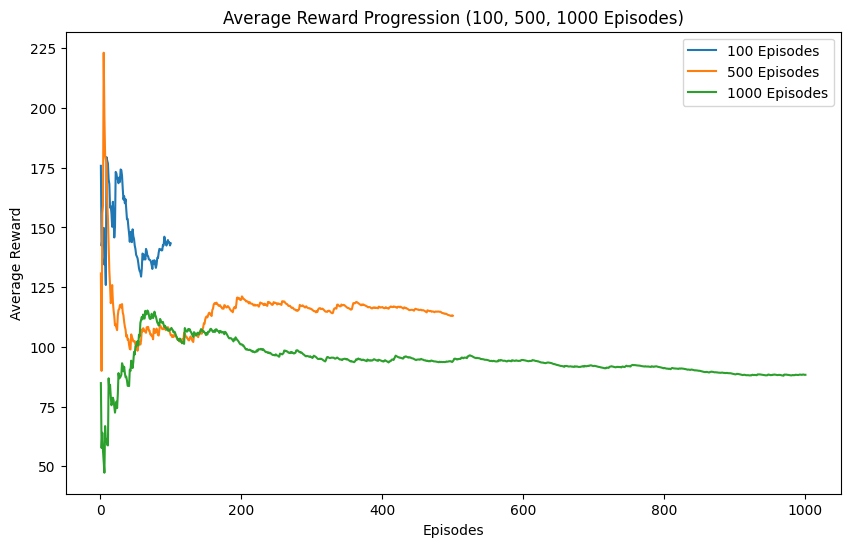

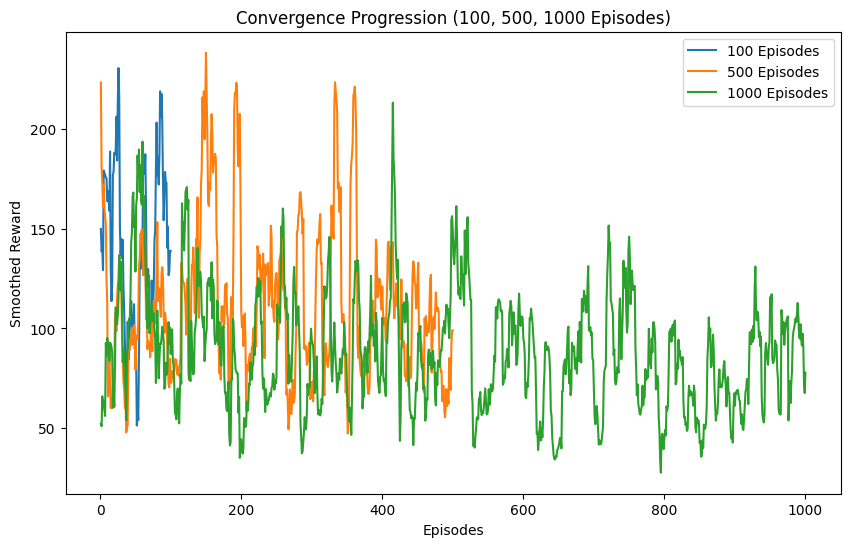


Combined Metrics Evaluation (100, 500, 1000 Episodes):
           Metric  100 Episodes  500 Episodes  1000 Episodes
 Price Elasticity    129.060548    115.954476      88.603302
Forecast Accuracy      0.513120      0.496846       0.499586
     Market Share      0.218651      0.170485       0.098179
      Price Index      0.218651      0.170485       0.098179
Price Consistency      0.007298      0.008658       0.011179
           Equity    129.060548    115.954476      88.603302


In [9]:


# Visualization for combined metrics and graphs for 100, 500, and 1000 episodes
def plot_combined_metrics_3(rewards_100, rewards_500, rewards_1000, exploration_history_100, exploration_history_500, exploration_history_1000):
    # Combined Cumulative Rewards
    cumulative_rewards_100 = np.cumsum(rewards_100)
    cumulative_rewards_500 = np.cumsum(rewards_500)
    cumulative_rewards_1000 = np.cumsum(rewards_1000)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_rewards_100) + 1), cumulative_rewards_100, label="100 Episodes")
    plt.plot(range(1, len(cumulative_rewards_500) + 1), cumulative_rewards_500, label="500 Episodes")
    plt.plot(range(1, len(cumulative_rewards_1000) + 1), cumulative_rewards_1000, label="1000 Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward Progression (100, 500, 1000 Episodes)")
    plt.legend()
    plt.show()

    # Combined Average Rewards per Episode
    average_rewards_100 = [np.mean(rewards_100[:i + 1]) for i in range(len(rewards_100))]
    average_rewards_500 = [np.mean(rewards_500[:i + 1]) for i in range(len(rewards_500))]
    average_rewards_1000 = [np.mean(rewards_1000[:i + 1]) for i in range(len(rewards_1000))]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(average_rewards_100) + 1), average_rewards_100, label="100 Episodes")
    plt.plot(range(1, len(average_rewards_500) + 1), average_rewards_500, label="500 Episodes")
    plt.plot(range(1, len(average_rewards_1000) + 1), average_rewards_1000, label="1000 Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Progression (100, 500, 1000 Episodes)")
    plt.legend()
    plt.show()

    # Combined Convergence (Smoothed Rewards)
    smoothed_rewards_100 = uniform_filter1d(rewards_100, size=10)
    smoothed_rewards_500 = uniform_filter1d(rewards_500, size=10)
    smoothed_rewards_1000 = uniform_filter1d(rewards_1000, size=10)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(smoothed_rewards_100) + 1), smoothed_rewards_100, label="100 Episodes")
    plt.plot(range(1, len(smoothed_rewards_500) + 1), smoothed_rewards_500, label="500 Episodes")
    plt.plot(range(1, len(smoothed_rewards_1000) + 1), smoothed_rewards_1000, label="1000 Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Reward")
    plt.title("Convergence Progression (100, 500, 1000 Episodes)")
    plt.legend()
    plt.show()


# Call the combined plotting function
plot_combined_metrics_3(rewards_100, rewards_500, rewards_1000, exploration_history_100, exploration_history_500, exploration_history_1000)




# Combined Metrics Evaluation for 100, 500, and 1000 Episodes
def combined_metrics_evaluation_3(rewards_100, rewards_500, rewards_1000):
    metrics_100 = compute_metrics(rewards_100)
    metrics_500 = compute_metrics(rewards_500)
    metrics_1000 = compute_metrics(rewards_1000)

    metrics_table = pd.DataFrame({
        "Metric": list(metrics_100.keys()),
        "100 Episodes": list(metrics_100.values()),
        "500 Episodes": list(metrics_500.values()),
        "1000 Episodes": list(metrics_1000.values())
    })

    print("\nCombined Metrics Evaluation (100, 500, 1000 Episodes):")
    print(metrics_table.to_string(index=False))


# Evaluate metrics for all episodes
combined_metrics_evaluation_3(rewards_100, rewards_500, rewards_1000)
